<a href="https://colab.research.google.com/github/smfwlgus/DnM/blob/master/baechu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm

import datetime
import urllib.request
import json

from glob import glob
import multiprocessing
import pickle

import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm
from lightgbm import LGBMRegressor, LGBMClassifier

In [2]:
# 경고 끄기
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')  #관련없는 문구 알리지 않음

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Capstone/Data/ten_pum_train_onebon.csv')
train = train[:1827] #2016 1 ~ 2020 12

In [4]:
weather = pd.read_csv('/content/drive/MyDrive/Capstone/주산지, 날씨 코드/weather.csv')
weather.head() #2015~2020 날씨 데이터

,no,stn_Code,stn_Name,date,temp,max_Temp,min_Temp,hum,widdir,wind,rain,sun_Time,sun_Qy,condens_Time,gr_Temp,soil_Temp,soil_Wt
0,1,536824B002,해남군 옥천면,2015-01-01,-1.3,0.6,-2.9,80.0,295.2,2.3,0.8,NaN,7.8,NaN,NaN,3.36,25.9
1,1,330846A001,천안시 목천읍,2015-01-01,-6.2,-3.8,-8.3,NaN,NaN,0.0,0.0,NaN,NaN,1429.0,NaN,NaN,NaN
2,1,627911A001,밀양시 상남면,2015-01-01,-3.2,0.2,-7.2,40.1,282.7,2.9,0.0,516.0,11.0,0.0,NaN,2.20,28.5
3,1,539823A001,진도군 군내면,2015-01-01,-0.8,1.6,-2.8,79.2,257.0,3.5,1.5,217.0,8.2,652.0,NaN,5.02,30.6
4,1,590823A001,남원시 이백면,2015-01-01,-4.1,-1.3,-6.0,60.7,286.7,2.1,0.5,310.0,7.7,0.0,-4.3,2.16,20.3


# preprocessing -> 사용x

In [ ]:
def preprocessing(temp_df, pum, len_lag) :
    # p_lag, q_lag 추가
    for lag in range(1,len_lag+1) : #1~29
      temp_df[f'p_lag_{lag}'] = -1 #q_lag_1_28 
      temp_df[f'q_lag_{lag}'] = -1 #p_lag_1~28 모두 -1로 채워두기
      for index in range(lag, len(temp_df)) : #1~temp_df 끝까지
        temp_df.loc[index, f'p_lag_{lag}'] = temp_df[f'{pum}_가격(원/kg)'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
        temp_df.loc[index, f'q_lag_{lag}'] = temp_df[f'{pum}_거래량(kg)'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가

    # month 추가
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    temp_df['month'] = temp_df['date'].dt.month

    # 예측 대상(1w,2w,4w) 추가
    for week in ['1_week','2_week','4_week'] :
      temp_df[week] = 0
      n_week = int(week[0])
      for index in range(len(temp_df)) :
        try : temp_df[week][index] = temp_df[f'{pum}_가격(원/kg)'][index+7*n_week]
        except : continue

    # 불필요한 column 제거        
    #temp_df = temp_df.drop(['date',f'{pum}_거래량(kg)',f'{pum}_가격(원/kg)'], axis=1)
    
    return temp_df

In [ ]:
# preprocessing 함수 예시
pum = '배추'
temp_df = train[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
preprocessing(temp_df, pum, len_lag=28)

# **전처리 - 이상치, 결측치**


*   모델 학습해보고 성능에 따라 조절할 듯



In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34263 entries, 0 to 34262
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   no            34263 non-null  int64  
 1   stn_Code      34263 non-null  object 
 2   stn_Name      34263 non-null  object 
 3   date          34263 non-null  object 
 4   temp          34258 non-null  float64
 5   max_Temp      34258 non-null  float64
 6   min_Temp      34227 non-null  float64
 7   hum           33518 non-null  float64
 8   widdir        30691 non-null  float64
 9   wind          34263 non-null  float64
 10  rain          34255 non-null  float64
 11  sun_Time      23537 non-null  float64
 12  sun_Qy        33610 non-null  float64
 13  condens_Time  28002 non-null  float64
 14  gr_Temp       18895 non-null  float64
 15  soil_Temp     29585 non-null  float64
 16  soil_Wt       17250 non-null  float64
dtypes: float64(13), int64(1), object(3)
memory usage: 4.4+ MB


In [6]:
weather.isnull().sum()

no                  0
stn_Code            0
stn_Name            0
date                0
temp                5
max_Temp            5
min_Temp           36
hum               745
widdir           3572
wind                0
rain                8
sun_Time        10726
sun_Qy            653
condens_Time     6261
gr_Temp         15368
soil_Temp        4678
soil_Wt         17013
dtype: int64

In [7]:
weather.fillna(0, inplace=True)

In [8]:
weather.isnull().sum()

no              0
stn_Code        0
stn_Name        0
date            0
temp            0
max_Temp        0
min_Temp        0
hum             0
widdir          0
wind            0
rain            0
sun_Time        0
sun_Qy          0
condens_Time    0
gr_Temp         0
soil_Temp       0
soil_Wt         0
dtype: int64

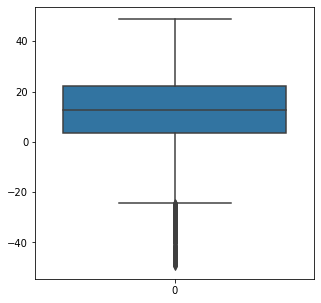

In [9]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=weather['soil_Temp'])

# **weather**

In [10]:
#주산지 정보들(코드 다시 돌리기 힘들때 사용하기 위해 미리 저장해둠) ---------------------> 주산지 10개
joosan_dict = {
              '깻잎': '경상남도 밀양시',
              '대파': '전라남도 신안군',
              '마늘': '경상남도 창녕군',
              '무': '제주도 제주시',
              '미나리': '경기도 시흥시',
              '배추': '전라남도 해남군',
              '시금치': '경기도 포천시',
              '양파': '전라남도 무안군',
              '토마토': '부산 강서구',
              '파프리카': '강원도 철원군'         
}

In [11]:
code_dict = { #-----------------> 10개 주산지 코드
    '강원도 철원군': '269811A001', #파프리카
    '경기도 시흥시': '429843A001', #미나리
    '경기도 포천시': '487915A001', #시금치
    '경상남도 밀양시': '627911A001', #깻잎
    '경상남도 창녕군': '635821A001', #마늘
    '부산 강서구': '618803A001', #토마토
    '전라남도 무안군': '534833E001', #양파
    '전라남도 신안군': '535812A001', #대파
    '전라남도 해남군': '536824B002', #배추
    '제주도 제주시': '063057B009', #무
}

In [12]:
first_date = datetime.datetime.strptime('2020-09-28', '%Y-%m-%d') - datetime.timedelta(360) #기준 날짜에서 360일 전 날짜까지 
date_list = [] 
for delta in range(360) : #0~360
    date = first_date + datetime.timedelta(days = delta)
    date = datetime.datetime.strftime(date, '%Y-%m-%d') 
    date_list.append(date)
date_df = pd.DataFrame({'date' : date_list}) #date가 담긴 df 생성

train = pd.read_csv('/content/drive/MyDrive/Capstone/Data/ten_pum_train_onebon.csv')
train = train[:1827] #2016 1 ~ 2020 12
train2 = pd.concat([date_df, train], sort = False).reset_index(drop=True) #1년치, 전체날짜(train)

In [13]:
# 배추 단일 품목 학습
pum = '양파' 
temp_df = train2[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']] 

# 품종과 주산지 날씨 mapping
joosanji = joosan_dict[pum] #주산지
joosan_code = code_dict[joosanji] #주산지 기상정보 관측 코드
joosan_weather = weather[weather['stn_Code']==joosan_code].reset_index(drop=True) #배추의 관측코드만 가져오기
end_index = np.where(joosan_weather['date']=='2020-12-31')[0][0] #2020-12-31
joosan_weather = joosan_weather.iloc[:end_index+1] #2020-12-31까지의 날씨 가져오기
temp_df = temp_df.merge(joosan_weather, on='date', how='left') 

# weather feature 추가
col_list = temp_df.columns[6:] #기상정보들
for num in range(1,13) : #--------------> 이거 지금 1개월 기준
  for index in range(360, len(temp_df)) :
    temp_quater_df = temp_df.iloc[index-30*num : index-30*(num-1)] #
    quater_temp = temp_quater_df['temp']
    temp_df.loc[index, f'rain_sum_{num}q'] = temp_quater_df['rain'].sum() # 누적 강수량
    
    temp_df.loc[index, f'heavy_rain_count_{num}q'] = np.where(temp_quater_df['rain']>90, 1, 0).sum() # 평균 강수량 90mm 이상 누적 일수
    temp_df.loc[index, f'low_temp_count_{num}q'] = np.where(quater_temp<5, 1, 0).sum() # 일평균 기온 5도 이하 누적 일수
    temp_df.loc[index, f'middle_temp_count_{num}q'] = np.where(((quater_temp>15)&(quater_temp<22)), 1, 0).sum() # 일평균 기온 15~22도 누적 일수
    temp_df.loc[index, f'high_temp_count_{num}q'] = np.where(quater_temp>32, 1, 0).sum() # 일평균 기온 32도 이상 누적 일수
    for col in col_list :
      temp_df.loc[index, f'avg_{col}_{num}q'] = temp_quater_df[col].mean() # 각 기상 요소의 평균값

In [14]:
#주차별 학습
for week in ['1_week','2_week','4_week'] :
  temp_df[week] = 0
  n_week = int(week[0]) #1, 2, 4
  for index in range(len(temp_df)) : 
    try : temp_df[week][index] = temp_df[f'{pum}_가격(원/kg)'][index+7*n_week] #index+ 7, 14, 28, 해당 날짜에서 7, 14, 28일 후의 날짜를 가져와서 저장
    except : continue
    
drop_col_list = temp_df.columns[3:19] 
temp_df = temp_df.drop(drop_col_list, 1).reset_index(drop=True)
temp_df = temp_df.iloc[360:].reset_index(drop=True)
temp_df = temp_df.drop(['date',f'{pum}_거래량(kg)',f'{pum}_가격(원/kg)'], axis=1) #날짜, 거래량, 가격 제거

temp_df

,rain_sum_1q,heavy_rain_count_1q,low_temp_count_1q,middle_temp_count_1q,high_temp_count_1q,avg_temp_1q,avg_max_Temp_1q,avg_min_Temp_1q,avg_hum_1q,avg_widdir_1q,avg_wind_1q,avg_rain_1q,avg_sun_Time_1q,avg_sun_Qy_1q,avg_condens_Time_1q,avg_gr_Temp_1q,avg_soil_Temp_1q,avg_soil_Wt_1q,rain_sum_2q,heavy_rain_count_2q,low_temp_count_2q,middle_temp_count_2q,high_temp_count_2q,avg_temp_2q,avg_max_Temp_2q,avg_min_Temp_2q,avg_hum_2q,avg_widdir_2q,avg_wind_2q,avg_rain_2q,avg_sun_Time_2q,avg_sun_Qy_2q,avg_condens_Time_2q,avg_gr_Temp_2q,avg_soil_Temp_2q,avg_soil_Wt_2q,rain_sum_3q,heavy_rain_count_3q,low_temp_count_3q,middle_temp_count_3q,...,avg_soil_Wt_10q,rain_sum_11q,heavy_rain_count_11q,low_temp_count_11q,middle_temp_count_11q,high_temp_count_11q,avg_temp_11q,avg_max_Temp_11q,avg_min_Temp_11q,avg_hum_11q,avg_widdir_11q,avg_wind_11q,avg_rain_11q,avg_sun_Time_11q,avg_sun_Qy_11q,avg_condens_Time_11q,avg_gr_Temp_11q,avg_soil_Temp_11q,avg_soil_Wt_11q,rain_sum_12q,heavy_rain_count_12q,low_temp_count_12q,middle_temp_count_12q,high_temp_count_12q,avg_temp_12q,avg_max_Temp_12q,avg_min_Temp_12q,avg_hum_12q,avg_widdir_12q,avg_wind_12q,avg_rain_12q,avg_sun_Time_12q,avg_sun_Qy_12q,avg_condens_Time_12q,avg_gr_Temp_12q,avg_soil_Temp_12q,avg_soil_Wt_12q,1_week,2_week,4_week
0,258.0,0.0,0.0,16.0,0.0,22.093333,26.893333,18.406667,93.370000,173.916667,0.910000,8.600000,311.133333,14.453333,0.0,23.136667,24.294333,27.430000,327.5,1.0,0.0,0.0,0.0,27.783333,31.946667,24.693333,94.540000,200.450000,0.906667,10.916667,349.466667,17.620000,0.0,29.166667,28.817667,25.896667,327.5,0.0,0.0,8.0,...,23.823333,37.5,0.0,3.0,1.0,0.0,9.333333,15.243333,3.950000,82.606667,224.513333,1.236667,1.250000,325.066667,9.866667,0.0,9.293333,11.452667,20.496667,9.0,0.0,0.0,17.0,0.0,15.113333,21.483333,9.583333,86.480000,169.210000,0.863333,0.30,416.200000,13.576667,0.0,15.803333,17.501667,24.943333,1218.0,1146.0,1322.0
1,247.5,0.0,1.0,16.0,0.0,21.303333,26.173333,17.526667,92.956667,177.496667,0.893333,8.250000,311.366667,14.263333,0.0,22.300000,23.522000,26.670000,332.0,1.0,0.0,0.0,0.0,27.790000,31.950000,24.673333,94.523333,198.453333,0.913333,11.066667,355.433333,17.646667,0.0,29.173333,28.870000,25.836667,327.5,0.0,0.0,7.0,...,23.750000,37.5,0.0,4.0,1.0,0.0,9.013333,14.870000,3.653333,82.443333,225.330000,1.240000,1.250000,317.166667,9.690000,0.0,8.973333,11.181667,20.736667,9.0,0.0,0.0,16.0,0.0,14.856667,21.230000,9.273333,86.253333,170.960000,0.870000,0.30,413.733333,13.420000,0.0,15.496667,17.257333,24.610000,1210.0,1150.0,1311.0
2,247.5,0.0,1.0,16.0,0.0,20.590000,25.526667,16.743333,92.713333,168.523333,0.886667,8.250000,296.433333,13.663333,0.0,21.450000,22.732000,25.933333,332.0,1.0,0.0,0.0,0.0,27.810000,31.996667,24.666667,94.456667,200.703333,0.920000,11.066667,366.566667,17.793333,0.0,29.216667,28.922000,25.773333,327.5,0.0,0.0,6.0,...,23.686667,37.5,0.0,5.0,1.0,0.0,8.723333,14.553333,3.370000,82.393333,223.540000,1.246667,1.250000,320.000000,9.636667,0.0,8.663333,10.918333,20.963333,9.0,0.0,0.0,15.0,0.0,14.700000,21.253333,9.133333,86.083333,162.470000,0.846667,0.30,425.733333,13.630000,0.0,15.360000,17.060000,24.303333,0.0,0.0,1061.0
3,232.5,0.0,1.0,16.0,0.0,19.916667,24.900000,16.033333,92.633333,176.166667,0.876667,7.750000,295.866667,13.406667,0.0,20.696667,21.981667,25.200000,347.0,1.0,0.0,0.0,0.0,27.806667,32.066667,24.653333,94.420000,197.173333,0.916667,11.566667,374.100000,17.933333,0.0,29.230000,28.979333,25.756667,327.5,0.0,0.0,6.0,...,23.626667,37.5,0.0,6.0,1.0,0.0,8.386667,14.096667,3.106667,82.043333,212.296667,1.273333,1.250000,315.300000,9.543333,0.0,8.323333,10.636667,21.183333,9.0,0.0,0.0,14.0,0.0,14.480000,21.056667,8.976667,86.173333,170.576667,0.860000,0.30,433.366667,13.620000,0.0,15.103333,16.871667,24.010000,1215.0,1176.0,1327.0
4,232.5,0.0,1.0,16.0,0.0,19.210000,24.210000,15.290000,92.266667,184.210000,0.880000,7.750000,298.733333,13.153333,0.0,19.910000,21.243333,24.440000,347.0,1.0,0.0,0.0,0.0,27.756667,32.060000,24.533333,94.410000,193.44

In [15]:
# season = ['봄', '여름', '가을', '겨울']

# for i in range(1, 13):
#   if (i==3) or (i==4) or (i==5):
#     temp_df.loc[index, f'season_{season}q'] = pd.concat([temp_df[index, f'rain_sum_{i}q']])
    

# temp_df

In [16]:
#nmae사용 
def nmae(week_answer, week_submission):
    answer = week_answer.to_numpy()
    target_idx = np.where(answer!=0)
    true = answer[target_idx]
    pred = week_submission[target_idx]
    score = np.mean(np.abs(true-pred)/true)
    
    return score

#1,2,4주의 평균으로 예측
def at_nmae(pred, dataset):
    y_true = dataset.get_label()
    week_1_answer = y_true[0::3]
    week_2_answer = y_true[1::3]
    week_4_answer = y_true[2::3]
    
    week_1_submission = pred[0::3]
    week_2_submission = pred[1::3]
    week_4_submission = pred[2::3]
    
    score1 = nmae(week_1_answer, week_1_submission)
    score2 = nmae(week_2_answer, week_2_submission)
    score4 = nmae(week_4_answer, week_4_submission)
    
    score = (score1+score2+score4)/3
    
    return 'score', score, False

In [17]:
def model_train(x_train, y_train, x_valid, y_valid) :
    params = {'learning_rate': 0.01, #학습률
              'max_depth': 6, #트리의 최대 깊이
              'boosting': 'gbdt', #실행하고자 하는 알고리즘 타입. 현재 디폴트 값인 gradient boosting decision tree
              'objective': 'regression',  #모델 어플리케이션. 현재 regression(회귀) --------------------------------------> 분류로도 해서 성능 비교하기*******
              'is_training_metric': True, 
              'num_leaves': 100, #전체 트리의 leave 수
              'feature_fraction': 0.8, #Light GBM이 트리를 만들 때 매번 각 iteration 반복에서 파라미터 80% 랜덤 선택
              'bagging_fraction': 0.8, #배깅, 매번 iteraion 돌 때 사용되는 데이터 80% 랜덤 선택
              'bagging_freq': 5, #배깅 빈도수
              'seed':42, #랜덤 시드
              'num_threads':8
             }
    #모델 Light GBM
    model = lightgbm.train(params, 
                   train_set = lightgbm.Dataset(data = x_train, label = y_train),
                   num_boost_round = 10000, #boosting iteraion 수. 10,000회
                   valid_sets = lightgbm.Dataset(data = x_valid, label = y_valid), #validation 세트 -> data에 x검증, label에 y검증
                   init_model = None, 
                   early_stopping_rounds = 100, #분석 속도 높이기. 지나친 iteration 줄이기
                   feval = at_nmae,
                   verbose_eval = False
                    )
    
    return model

In [18]:
model_dict = {} #배추만 학습시켜보기
split = 28 #전체 100 중 validation용으로 나눔

# 주차별(1,2,4w) 학습
for week_num in [1,2,4] :
  x = temp_df[temp_df[f'{week_num}_week']>0].iloc[:,:-3] 
  y = temp_df[temp_df[f'{week_num}_week']>0][f'{week_num}_week']
        
  #train, test split
  x_train = x[:-split]
  y_train = y[:-split]
  x_valid = x[-split:]
  y_valid = y[-split:]
        
  model_dict[f'{pum}_model_{week_num}'] = model_train(x_train, y_train, x_valid, y_valid)

In [20]:
submission = pd.read_csv('/content/drive/MyDrive/Capstone/Data/subsub.csv') #10개 품목 있는거  12-2
#여기에도 날짜 추가하기 어제꺼 날짜 추가하기 자동화
#submission = submission[114:]

test_T = pd.read_csv('/content/drive/MyDrive/Capstone/Data/test_yesterday.csv') #12-2
#public_date_list = test_T[test_T['date'].str.contains('2021')]['date'].str.split('+').str[0].unique()
#['2021-01-01', ...] 

public_date_list = submission[submission['예측대상일자'].str.contains('2021')]['예측대상일자'].str.split('+').str[0].unique()

for date in tqdm(public_date_list) : #빈 submission 파일 불러오기
    #if os.path.isfile(f'/content/drive/MyDrive/Capstone/private_data/test_files/test_{date}.csv'): 
    test = pd.read_csv(f'/content/drive/MyDrive/Capstone/Data/test_files/test_{date}.csv') #예측날짜에 맞춘 csv다시 만들기
    
    # 예측기준일에 대해 전처리
    temp_test = pd.DataFrame([{'date' : date}]) #test_files에 있는 예측기준일(date)
    alldata = pd.concat([train, test, temp_test], sort=False).reset_index(drop=True) 
    #[train, test, temp_test연결], sort 기본값, reset_index(drop=True)는 이전 인덱스가 열로 추가되는 것 방지  
    alldata = alldata[['date', f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']].fillna(0) #모든 데이터에서 값이 없는 부분(na) -> 0으로 채우기 
    alldata = alldata.iloc[-28:].reset_index(drop=True) #-28(마지막) 가져오기, drop=True는 인덱스 열 버리기
          
    #alldata = preprocessing(alldata, pum, len_lag=28) #전처리(모든 데이터, pum, 28) *수정필요*
    #alldata = weather_feature(alldata, date_df, weather, pum, joosan_dict, code_dict, quater_days=30, num_quaters=12) #날씨 전처리로 추가, temp_df 지움
    alldata = temp_df

    temp_test = alldata.iloc[-1].astype(float) #iloc[-1], 마지막 행을 float 타입으로 가져오기

    # 개별 모델을 활용하여 1,2,4주 후 가격 예측
    for week_num in [1,2,4] : #week_num: 1,2,4
      temp_model = model_dict[f'{pum}_model_{week_num}']
      result = temp_model.predict(temp_test) #temp_test의 예측값
      condition = (submission['예측대상일자']==f'{date}+{week_num}week') #ex.[2020-09-29 + 1week]
      idx = submission[condition].index #인덱스
      submission.loc[idx, f'{pum}_가격(원/kg)'] = result[0] #loc은 레이블 기반이라 행.열 설정해줘야함
      #행 idx, 열은 pum들의 가격(원/kg) 인덱스
      #주차 별로 품목 바꾸면서 가격 가져오기

preds = temp_model.predict(alldata)

100%|██████████| 336/336 [01:27<00:00,  3.82it/s]


In [ ]:
submission.to_csv('/content/drive/MyDrive/Capstone/submission_1203.csv',index=False)

# **모델 저장**

In [ ]:
!pip install joblib
import joblib

joblib.dump(temp_model, '/content/drive/MyDrive/Capstone/lgbm.pkl')
load_model = joblib.load('/content/drive/MyDrive/Capstone/lgbm.pkl')

# **SUBMISSION**

In [22]:
#어제의 농넷 데이터 불러오기
#datetime.datetime(2019, 12, 12)...
today = datetime.datetime.today()
yesterday = (today-datetime.timedelta(1)).strftime('%Y%m%d') #strftime(): 원하는 날짜 형식으로 출력

url = 'https://www.nongnet.or.kr/api/whlslDstrQr.do?sdate=' # sdate = 날짜

response = urllib.request.urlopen(url+yesterday).read()
response = json.loads(response)

data = pd.DataFrame(response['data'])

In [23]:
yesterday

'20211203'

In [24]:
data

,PUM_NM,LV_NM,TOT_AMT,SAN_NM,SALEDATE,CMP_NM,DAN_NM,WHSAL_NM,SIZE_NM,COST,POJ_NM,TOT_QTY,QTY,KIND_NM,DANQ
0,수박,특,85000,충남 부여군,20211203,대인농산,kg,인천구월도매,.,8500,상자,60.0,10.0,기타수박,6.0
1,수박,상,50000,충남 부여군,20211203,대인농산,kg,인천구월도매,.,10000,상자,40.0,5.0,기타수박,8.0
2,수박,4등,4000,충남 부여군,20211203,대인농산,kg,인천구월도매,.,4000,상자,8.0,1.0,기타수박,8.0
3,감귤,특,288000,제주 서귀포시,20211203,대인농산,kg,인천구월도매,.,4500,상자,320.0,64.0,기타감귤,5.0
4,감귤,특,291500,제주 서귀포시,20211203,대인농산,kg,인천구월도매,.,5500,상자,265.0,53.0,기타감귤,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91861,바나나,.,464000,None,20211203,강서청과,kg,서울강서도매,1개(내_뿌리),16000,.,377.0,29.0,바나나(수입),13.0
91862,바나나,.,64000,None,20211203,강서청과,kg,서울강서도매,1개(내_뿌리),16000,.,52.0,4.0,바나나(수입),13.0
91863,바나나,.,80000,None,20211203,강서청과,kg,서울강서도매,1개(내_뿌리),16000,.,65.0,5.0,바나나(수입),13.0
91864,쪽파,.,-165000,None,20211203,강서청과,kg,서울강서도매,1개(내_뿌리),33000,상자,-50.0,-5.0,쪽파(일반),10.0


In [67]:
data.to_csv(f'/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/AT_TSALET_ALL_{yesterday}.csv', index=False)

In [68]:
# 윈도우즈 사용시 함수를 별도의 .py파일로 저장 후 import하여 사용
def preprocessing(tsalet_file):
    unique_pum = [
        '배추', '무', '양파', '마늘', '대파', 
        '깻잎', '시금치', '미나리', '파프리카', '토마토',
    ]
    
    t_dict = {
        'date':[]
    }
    
    for sub in unique_pum:
        t_dict[f'{sub}_거래량(kg)'] = []
        t_dict[f'{sub}_가격(원/kg)'] = []
        
    tsalet_sample = pd.read_csv(tsalet_file)
    days = sorted(tsalet_sample['SALEDATE'].unique())
    for day in days:
        t_dict['date'].append(day)
        for sub in unique_pum:
            # 날짜별, 품목별, 거래량이 0 이상인 행만 선택
            c = tsalet_sample[(tsalet_sample['SALEDATE']==day) & (tsalet_sample['PUM_NM']==sub) & (tsalet_sample['TOT_QTY']>=0)]
            if c.shape[0] == 0:
                t_dict[f'{sub}_거래량(kg)'].append(0)
                t_dict[f'{sub}_가격(원/kg)'].append(0)
            else:
                tot_amt = c['TOT_AMT'].sum().astype(float)
                tot_qty = c['TOT_QTY'].sum().astype(float)
                mean_price = tot_amt/(tot_qty+1e-20)
                t_dict[f'{sub}_거래량(kg)'].append(tot_qty)
                t_dict[f'{sub}_가격(원/kg)'].append(mean_price)
                
    with open(f'/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/{tsalet_file.split("/")[-1].split(".")[0]}.pkl', 'wb') as f:
        pickle.dump(t_dict, f)

In [69]:
#tsalet_files = sorted(glob('/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/*'))
tsalet_files = sorted(glob(f'/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/AT_TSALET_ALL_{yesterday}.csv')) 

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
pool.map(preprocessing, tsalet_files)
pool.close()
pool.join()

In [70]:
dict_files = sorted(glob(f'/content/drive/MyDrive/Capstone/Data/test_AT_TSALET_ALL/AT_TSALET_ALL_{yesterday}.pkl'))

In [71]:
t_dict_list = []
for dict_file in dict_files:
    with open(dict_file, 'rb') as f:
        train_dict = pickle.load(f)
    t_dict_list.append(train_dict)

In [105]:
train = None

for t_dcit in t_dict_list:
    if train is None:
        train = pd.DataFrame(t_dcit)
    else:
        train = pd.concat([train, pd.DataFrame(t_dcit)])

In [106]:
train['date'] = train.date.astype(str).str.replace('-','')
train['date'] = pd.to_datetime(train.date, format='%Y%m%d')

In [107]:
train

,date,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg)
0,2021-12-03,2240760.1,886.985342,1502845.2,455.352038,1614193.9,796.58222,132291.6,6445.476259,553619.6,1438.332909,60559.5,6088.198383,216081.3,2515.163681,76514.6,6814.752805,125767.1,2311.520573,183210.9,2505.97126


In [108]:
train.insert(1, '요일', '0')

In [109]:
import datetime #20/9/29~20/11/5
days = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

for i in range (train.shape[0]): #문자 -> 숫자
  train['요일'][i] = days[int(train['date'].dt.weekday[i])]

In [110]:
train['date'] = train['date'].dt.date

In [111]:
test = pd.read_csv('/content/drive/MyDrive/Capstone/Data/test_yesterday.csv')
test

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg)
0,2021-01-01,금요일,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,2021-01-02,토요일,24401.50,388.534188,21461.0,559.526583,20606.0,1058.393186,2408.0,5129.931063,27859.0,2384.020245,4079.5,13150.276995,9920.00,2642.957863,7033.0,1614.409498,7849.0,4884.721875,25290.0,1914.895216
2,2021-01-03,일요일,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,2021-01-04,월요일,859651.80,441.499637,1665261.7,542.826183,1823037.4,1266.627437,121200.4,5425.898627,874594.6,2202.568178,112324.7,9501.869972,374131.63,2966.183666,79020.5,3509.511798,150290.6,4515.337752,393979.0,2098.278649
4,2021-01-05,화요일,889332.20,412.451877,1647835.5,570.874791,1513826.0,1329.721668,125712.0,5147.233605,765322.2,2240.754967,69850.2,11128.609839,295523.20,3111.929321,74112.0,3965.334750,89124.0,5515.671581,228576.5,2092.442574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2021-11-30,화요일,2185300.05,733.173048,1718213.9,418.116762,1494509.0,753.684039,120348.6,6278.178749,578445.3,1249.963497,56564.5,6505.918429,231467.55,2242.437702,75398.8,6544.052319,159247.3,2225.523196,176793.4,2358.261281
334,2021-12-01,수요일,1517157.50,814.134951,1515337.4,355.843013,1713024.7,804.114206,159602.7,6826.912909,513202.7,1398.334826,61748.9,6717.704607,220261.97,2417.830949,86655.6,6068.800828,162380.7,2134.811434,190878.7,2507.076484
335,2021-12-02,목요일,1517168.60,854.298249,955693.7,395.180976,1586469.1,773.716986,93316.7,6752.165754,515073.5,1459.508031,60809.6,6067.539204,169262.65,2258.844447,46633.5,5603.047616,125224.1,2245.025486,123034.5,2424.799223
336,2021-12-03,금요일,2240760.10,886.985342,1502845.2,455.352038,1614193.9,796.582220,132291.6,6445.476259,553619.6,1438.332909,60559.5,6088.198383,216081.30,2515.163681,76514.6,6814.752805,125767.1,2311.520573,183210.9,2505.971260


In [101]:
test = test.append(train)
test

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg)
0,2021-01-01,금요일,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,2021-01-02,토요일,24401.50,388.534188,21461.0,559.526583,20606.0,1058.393186,2408.0,5129.931063,27859.0,2384.020245,4079.5,13150.276995,9920.00,2642.957863,7033.0,1614.409498,7849.0,4884.721875,25290.0,1914.895216
2,2021-01-03,일요일,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,2021-01-04,월요일,859651.80,441.499637,1665261.7,542.826183,1823037.4,1266.627437,121200.4,5425.898627,874594.6,2202.568178,112324.7,9501.869972,374131.63,2966.183666,79020.5,3509.511798,150290.6,4515.337752,393979.0,2098.278649
4,2021-01-05,화요일,889332.20,412.451877,1647835.5,570.874791,1513826.0,1329.721668,125712.0,5147.233605,765322.2,2240.754967,69850.2,11128.609839,295523.20,3111.929321,74112.0,3965.334750,89124.0,5515.671581,228576.5,2092.442574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2021-11-30,화요일,2185300.05,733.173048,1718213.9,418.116762,1494509.0,753.684039,120348.6,6278.178749,578445.3,1249.963497,56564.5,6505.918429,231467.55,2242.437702,75398.8,6544.052319,159247.3,2225.523196,176793.4,2358.261281
334,2021-12-01,수요일,1517157.50,814.134951,1515337.4,355.843013,1713024.7,804.114206,159602.7,6826.912909,513202.7,1398.334826,61748.9,6717.704607,220261.97,2417.830949,86655.6,6068.800828,162380.7,2134.811434,190878.7,2507.076484
335,2021-12-02,목요일,1517168.60,854.298249,955693.7,395.180976,1586469.1,773.716986,93316.7,6752.165754,515073.5,1459.508031,60809.6,6067.539204,169262.65,2258.844447,46633.5,5603.047616,125224.1,2245.025486,123034.5,2424.799223
0,2021-12-03,금요일,2240760.10,886.985342,1502845.2,455.352038,1614193.9,796.582220,132291.6,6445.476259,553619.6,1438.332909,60559.5,6088.198383,216081.30,2515.163681,76514.6,6814.752805,125767.1,2311.520573,183210.9,2505.971260


In [115]:
test.to_csv('/content/drive/MyDrive/Capstone/Data/test_yesterday.csv', index=False)

In [137]:
yes = (today-datetime.timedelta(1)).strftime('%Y-%m-%d')
test.to_csv(f'/content/drive/MyDrive/Capstone/Data/test_files/test_{yes}.csv', index=False)

In [81]:
#submission코드 다시
submission = pd.read_csv('/content/drive/MyDrive/Capstone/Data/subsub.csv') #10개 품목 있는거  12-3

In [82]:
for week_num in [1,2,4]:
  yes = (today-datetime.timedelta(1)).strftime('%Y-%m-%d')
  submission.loc[len(submission)] = [f'{yes}+{week_num}week', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [83]:
submission

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),깻잎_가격(원/kg),시금치_가격(원/kg),미나리_가격(원/kg),파프리카_가격(원/kg),토마토_가격(원/kg)
0,2021-01-01+1week,0,0,0,0,0,0,0,0,0,0
1,2021-01-01+2week,0,0,0,0,0,0,0,0,0,0
2,2021-01-01+4week,0,0,0,0,0,0,0,0,0,0
3,2021-01-02+1week,0,0,0,0,0,0,0,0,0,0
4,2021-01-02+2week,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1006,2021-12-02+2week,0,0,0,0,0,0,0,0,0,0
1007,2021-12-02+4week,0,0,0,0,0,0,0,0,0,0
1008,2021-12-03+1week,0,0,0,0,0,0,0,0,0,0
1009,2021-12-03+2week,0,0,0,0,0,0,0,0,0,0


In [85]:
#submission코드 다시
submission.to_csv('/content/drive/MyDrive/Capstone/Data/subsub.csv', index=False) #10개 품목 있는거  12-3

In [142]:
test_T = pd.read_csv('/content/drive/MyDrive/Capstone/Data/test_yesterday.csv') #12-2
#public_date_list = test_T[test_T['date'].str.contains('2021')]['date'].str.split('+').str[0].unique()
#['2021-01-01', ...] 

public_date_list = submission[submission['예측대상일자'].str.contains('2021')]['예측대상일자'].str.split('+').str[0].unique()

for date in tqdm(public_date_list) : #빈 submission 파일 불러오기
    #if os.path.isfile(f'/content/drive/MyDrive/Capstone/private_data/test_files/test_{date}.csv'): 
    test = pd.read_csv(f'/content/drive/MyDrive/Capstone/Data/test_files/test_{date}.csv') #예측날짜에 맞춘 csv다시 만들기
    
    # 예측기준일에 대해 전처리
    temp_test = pd.DataFrame([{'date' : date}]) #test_files에 있는 예측기준일(date)
    alldata = pd.concat([train, test, temp_test], sort=False).reset_index(drop=True) 
    #[train, test, temp_test연결], sort 기본값, reset_index(drop=True)는 이전 인덱스가 열로 추가되는 것 방지  
    alldata = alldata[['date', f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']].fillna(0) #모든 데이터에서 값이 없는 부분(na) -> 0으로 채우기 
    alldata = alldata.iloc[-28:].reset_index(drop=True) #-28(마지막) 가져오기, drop=True는 인덱스 열 버리기
          
    #alldata = preprocessing(alldata, pum, len_lag=28) #전처리(모든 데이터, pum, 28) *수정필요*
    #alldata = weather_feature(alldata, date_df, weather, pum, joosan_dict, code_dict, quater_days=30, num_quaters=12) #날씨 전처리로 추가, temp_df 지움
    alldata = temp_df

    temp_test = alldata.iloc[-1].astype(float) #iloc[-1], 마지막 행을 float 타입으로 가져오기

    # 개별 모델을 활용하여 1,2,4주 후 가격 예측
    for week_num in [1,2,4] : #week_num: 1,2,4
      temp_model = model_dict[f'{pum}_model_{week_num}']
      result = np.round(temp_model.predict(temp_test),0) #temp_test의 예측값
      condition = (submission['예측대상일자']==f'{date}+{week_num}week') #ex.[2020-09-29 + 1week]
      idx = submission[condition].index #인덱스
      submission.loc[idx, f'{pum}_가격(원/kg)'] = result[0] #loc은 레이블 기반이라 행.열 설정해줘야함
      #행 idx, 열은 pum들의 가격(원/kg) 인덱스
      #주차 별로 품목 바꾸면서 가격 가져오기

preds = temp_model.predict(alldata)

100%|██████████| 337/337 [00:07<00:00, 46.77it/s]


In [143]:
submission.to_csv('/content/drive/MyDrive/Capstone/submission_1203.csv',index=False)

**끝**

In [ ]:
from sklearn.metrics import confusion_matrix, r2_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [ ]:
def get_eval(y_test, y_pred): #지금 회귀고 결과가 가격을 예측하는거라서 이걸 못씀
  accuracy = accuracy_score(y_test, y_pred)
  confusion = confusion_matrix(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  F1 = f1_score(y_test, y_pred)
  AUC = roc_auc_score(y_test, y_pred)

  print('오차행렬: \n', confusion)
  print('\n정확도: ', accuracy)
  print('정밀도: ', precision)
  print('재현률: ', recall)
  print('f1-score: ', F1)
  print('AUC: ', AUC)

In [ ]:
real = train['양파_거래량(kg)'].to_numpy()

In [ ]:
acc = r2_score(real, preds)

In [ ]:
acc

-3.034477066315808

# sub

In [ ]:
st = pd.read_csv('/content/drive/MyDrive/Capstone/Data/ten_pum_sub.csv')

In [ ]:
st.head() #2021-11-01 ~ 2021-11-30 -> 2021-01-01~2021-10-31

,Unnamed: 0,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),깻잎_가격(원/kg),시금치_가격(원/kg),미나리_가격(원/kg),파프리카_가격(원/kg),토마토_가격(원/kg)
0,0,2021-11-01+1week,0,0,0,0,0,0,0,0,0,0
1,1,2021-11-01+2week,0,0,0,0,0,0,0,0,0,0
2,2,2021-11-01+4week,0,0,0,0,0,0,0,0,0,0
3,3,2021-11-02+1week,0,0,0,0,0,0,0,0,0,0
4,4,2021-11-02+2week,0,0,0,0,0,0,0,0,0,0


In [ ]:
st = st.drop(['예측대상일자', 'Unnamed: 0'], 1)

In [ ]:
st.columns

Index(['배추_가격(원/kg)', '무_가격(원/kg)', '양파_가격(원/kg)', '마늘_가격(원/kg)',
       '대파_가격(원/kg)', '깻잎_가격(원/kg)', '시금치_가격(원/kg)', '미나리_가격(원/kg)',
       '파프리카_가격(원/kg)', '토마토_가격(원/kg)'],
      dtype='object')

In [ ]:
#2021-11-01 ~ 2021-11-30 -> 2021-01-01~2021-10-31
# for week_num in [1,2,4] :
# condition = (submission['예측대상일자']==f'{date}+{week_num}week') #ex.[2020-09-29 + 1week]

In [ ]:
first_date = datetime.datetime.strptime('2021-01-01', '%Y-%m-%d') #기준 날짜에서 360일 전 날짜까지 
end_date = datetime.datetime.strptime('2021-10-31', '%Y-%m-%d')

In [ ]:
date_list = [] 
for delta in range(304) : #0~360
    date = first_date + datetime.timedelta(days = delta)
    date = datetime.datetime.strftime(date, '%Y-%m-%d')
    for wnum in [1,2,4] : 
      date_list.append(f'{date}+{wnum}week')
date_df = pd.DataFrame({'예측대상일자' : date_list}) #date가 담긴 df 생성

In [ ]:
date_df

,예측대상일자
0,2021-01-01+1week
1,2021-01-01+2week
2,2021-01-01+4week
3,2021-01-02+1week
4,2021-01-02+2week
...,...
907,2021-10-30+2week
908,2021-10-30+4week
909,2021-10-31+1week
910,2021-10-31+2week


In [ ]:
ste = pd.concat([date_df, st], sort = False).reset_index(drop=True)

In [ ]:
ste = ste[:912]
ste

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),깻잎_가격(원/kg),시금치_가격(원/kg),미나리_가격(원/kg),파프리카_가격(원/kg),토마토_가격(원/kg)
0,2021-01-01+1week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01+2week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01+4week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-02+1week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-02+2week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
907,2021-10-30+2week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
908,2021-10-30+4week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
909,2021-10-31+1week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
910,2021-10-31+2week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
unique = [ #--------------------------------------------------------------> 품종 버리고 품목 축소 10개로
    '배추', '무', '양파', '마늘', '대파', 
    '깻잎', '시금치', '미나리', '파프리카', '토마토',
]

In [ ]:
for pum in unique:
  ste[f'{pum}_가격(원/kg)'] = 0

In [ ]:
ste

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),깻잎_가격(원/kg),시금치_가격(원/kg),미나리_가격(원/kg),파프리카_가격(원/kg),토마토_가격(원/kg)
0,2021-01-01+1week,0,0,0,0,0,0,0,0,0,0
1,2021-01-01+2week,0,0,0,0,0,0,0,0,0,0
2,2021-01-01+4week,0,0,0,0,0,0,0,0,0,0
3,2021-01-02+1week,0,0,0,0,0,0,0,0,0,0
4,2021-01-02+2week,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
907,2021-10-30+2week,0,0,0,0,0,0,0,0,0,0
908,2021-10-30+4week,0,0,0,0,0,0,0,0,0,0
909,2021-10-31+1week,0,0,0,0,0,0,0,0,0,0
910,2021-10-31+2week,0,0,0,0,0,0,0,0,0,0


In [ ]:
ste.to_csv('/content/drive/MyDrive/Capstone/Data/newsub.csv', index=False)

In [ ]:
train2 = pd.concat([date_df, train], sort = False).reset_index(drop=True)

# **함수 없는 코드** 

In [ ]:
first_date = datetime.datetime.strptime('2020-09-28', '%Y-%m-%d') - datetime.timedelta(360) #----------#
date_list = [] 
for delta in range(360) :
    date = first_date + datetime.timedelta(days = delta)
    date = datetime.datetime.strftime(date, '%Y-%m-%d') 
    date_list.append(date)
date_df = pd.DataFrame({'date' : date_list})
train = pd.read_csv('/content/drive/MyDrive/Capstone/Data/ten_pum_train_onebon.csv')
train = train[:1827] #2016 1 ~ 2020 12
train2 = pd.concat([date_df, train], sort = False).reset_index(drop=True) #2015~2020-09-28

In [ ]:
# def weather_feature(temp_df, train2, date_df, allweather, pum, joosan_dict, code_dict, quater_days=30, num_quaters=12) :
    # 2015년도 일자 추가
pum = '배추' #
temp_df = train2[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']] #------->이거 지움
    
    # 품종과 주산지 날씨 mapping
joosanji = joosan_dict[pum]
joosan_code = code_dict[joosanji]
joosan_weather = weather[weather['stn_Code']==joosan_code].reset_index(drop=True) #여기서 weather 바꿈
end_index = np.where(joosan_weather['date']=='2020-12-31')[0][0] #----------#
joosan_weather = joosan_weather.iloc[:end_index+1] #2020-12-31 까지 들어감
temp_df = temp_df.merge(joosan_weather, on='date', how='left') #여기서부터 확인하기

    # weather feature 추가
col_list = temp_df.columns[6:]
for num in range(1,13) : #
  for index in range(360, len(temp_df)) :
    temp_quater_df = temp_df.iloc[index-30*num : index-30*(num-1)] #
    quater_temp = temp_quater_df['temp']
    temp_df.loc[index, f'rain_sum_{num}q'] = temp_quater_df['rain'].sum() # 누적 강수량
    
    temp_df.loc[index, f'heavy_rain_count_{num}q'] = np.where(temp_quater_df['rain']>90, 1, 0).sum() # 평균 강수량 90mm 이상 누적 일수
    temp_df.loc[index, f'low_temp_count_{num}q'] = np.where(quater_temp<5, 1, 0).sum() # 일평균 기온 5도 이하 누적 일수
    temp_df.loc[index, f'middle_temp_count_{num}q'] = np.where(((quater_temp>15)&(quater_temp<22)), 1, 0).sum() # 일평균 기온 15~22도 누적 일수
    temp_df.loc[index, f'high_temp_count_{num}q'] = np.where(quater_temp>32, 1, 0).sum() # 일평균 기온 32도 이상 누적 일수
    for col in col_list :
      temp_df.loc[index, f'avg_{col}_{num}q'] = temp_quater_df[col].mean() # 각 기상 요소의 평균값
    
drop_col_list = temp_df.columns[3:19]
temp_df = temp_df.drop(drop_col_list, 1).reset_index(drop=True)
temp_df = temp_df.iloc[360:].reset_index(drop=True)
temp_df

,date,배추_거래량(kg),배추_가격(원/kg),rain_sum_1q,heavy_rain_count_1q,low_temp_count_1q,middle_temp_count_1q,high_temp_count_1q,avg_temp_1q,avg_max_Temp_1q,avg_min_Temp_1q,avg_hum_1q,avg_widdir_1q,avg_wind_1q,avg_rain_1q,avg_sun_Time_1q,avg_sun_Qy_1q,avg_condens_Time_1q,avg_gr_Temp_1q,avg_soil_Temp_1q,avg_soil_Wt_1q,rain_sum_2q,heavy_rain_count_2q,low_temp_count_2q,middle_temp_count_2q,high_temp_count_2q,avg_temp_2q,avg_max_Temp_2q,avg_min_Temp_2q,avg_hum_2q,avg_widdir_2q,avg_wind_2q,avg_rain_2q,avg_sun_Time_2q,avg_sun_Qy_2q,avg_condens_Time_2q,avg_gr_Temp_2q,avg_soil_Temp_2q,avg_soil_Wt_2q,rain_sum_3q,...,avg_condens_Time_10q,avg_gr_Temp_10q,avg_soil_Temp_10q,avg_soil_Wt_10q,rain_sum_11q,heavy_rain_count_11q,low_temp_count_11q,middle_temp_count_11q,high_temp_count_11q,avg_temp_11q,avg_max_Temp_11q,avg_min_Temp_11q,avg_hum_11q,avg_widdir_11q,avg_wind_11q,avg_rain_11q,avg_sun_Time_11q,avg_sun_Qy_11q,avg_condens_Time_11q,avg_gr_Temp_11q,avg_soil_Temp_11q,avg_soil_Wt_11q,rain_sum_12q,heavy_rain_count_12q,low_temp_count_12q,middle_temp_count_12q,high_temp_count_12q,avg_temp_12q,avg_max_Temp_12q,avg_min_Temp_12q,avg_hum_12q,avg_widdir_12q,avg_wind_12q,avg_rain_12q,avg_sun_Time_12q,avg_sun_Qy_12q,avg_condens_Time_12q,avg_gr_Temp_12q,avg_soil_Temp_12q,avg_soil_Wt_12q
0,2016-01-01,0.0,0.0,249.5,0.0,0.0,21.0,0.0,21.116667,26.186667,17.276667,91.950000,188.980000,0.473333,8.316667,260.133333,12.863333,NaN,NaN,24.163333,NaN,168.0,0.0,0.0,0.0,0.0,26.743333,31.020000,23.610000,93.443333,162.580000,0.736667,5.600000,276.266667,15.130000,NaN,NaN,27.260667,NaN,362.0,...,NaN,NaN,6.961667,25.980000,44.5,0.0,5.0,1.0,0.0,8.620000,15.126667,2.350000,80.323333,250.700000,0.713333,1.483333,284.766667,9.413333,NaN,NaN,12.410333,19.673333,9.0,0.0,0.0,13.0,0.0,14.350000,21.443333,8.353333,84.096667,242.513333,0.453333,0.300000,368.033333,13.353333,NaN,NaN,18.095667,23.143333
1,2016-01-02,80860.0,329.0,233.1,0.0,1.0,21.0,0.0,20.313333,25.496667,16.306667,91.423333,194.536667,0.466667,7.770000,266.241379,12.856667,NaN,NaN,23.400333,23.300000,183.5,0.0,0.0,0.0,0.0,26.720000,30.966667,23.590000,93.480000,162.286667,0.743333,6.116667,272.166667,14.920000,NaN,NaN,27.316333,NaN,360.5,...,NaN,NaN,6.815333,25.966667,44.5,0.0,6.0,1.0,0.0,8.313333,14.720000,2.033333,79.916667,250.610000,0.720000,1.483333,278.633333,9.270000,NaN,NaN,12.194333,20.126667,9.0,0.0,0.0,12.0,0.0,14.086667,21.213333,8.026667,83.833333,248.693333,0.456667,0.300000,368.166667,13.246667,NaN,NaN,17.854667,22.576667
2,2016-01-03,0.0,0.0,232.6,0.0,1.0,21.0,0.0,19.596667,24.846667,15.513333,91.230000,187.063333,0.463333,7.753333,261.214286,12.423333,NaN,NaN,22.651667,23.300000,184.0,0.0,0.0,0.0,0.0,26.710000,30.996667,23.553333,93.576667,169.393333,0.743333,6.133333,273.333333,14.893333,NaN,NaN,27.359333,NaN,360.5,...,NaN,NaN,6.711667,25.970000,43.5,0.0,7.0,1.0,0.0,8.016667,14.436667,1.773333,79.686667,256.443333,0.720000,1.450000,278.833333,9.240000,NaN,NaN,11.968000,20.566667,10.0,0.0,0.0,11.0,0.0,13.886667,21.220000,7.790000,83.846667,242.803333,0.433333,0.333333,377.433333,13.343333,NaN,NaN,17.633333,22.046667
3,2016-01-04,1422742.5,478.0,232.6,0.0,1.0,21.0,0.0,18.903333,24.323333,14.756667,91.120000,193.300000,0.453333,7.753333,249.407407,12.076667,NaN,NaN,21.911333,23.233333,184.0,0.0,0.0,0.0,0.0,26.750000,31.066667,23.606667,93.486667,169.020000,0.746667,6.133333,287.666667,15.130000,NaN,NaN,27.424333,NaN,360.5,...,NaN,NaN,6.622333,25.976667,43.5,0.0,8.0,1.0,0.0,7.650000,14.003333,1.426667,79.320000,256.643333,0.743333,1.450000,280.100000,9.180000,NaN,NaN,11.708333,20.993333,10.0,0.0,0.0,10.0,0.0,13.693333,21.073333,7.590000,83.866667,249.310000,0.430000,0.333333,376.000000,13.273333,NaN,NaN,17.448000,21.543333
4,2016-01-05,1167241.0,442.0,232.6,0.0,1.0,21.0,0.0,18.240000,23.700000,13.950000,90.760000,200.016667,0.463333,7.753333,246.307692,11.873333,NaN,NaN,21.186667,23.175000,183.5,0.0,0.0,0.0,0.0,26.710000,31.056667,23.540000,93.436667,167.146667,0.743333,6.116667,290.366667,15.100000,NaN,NaN,